**LINE**

LINE is an unsupervised algorithm trying to capture the first order proximity or the second order proximity to learn the representation of nodes. 

In this paper, all the edges should be seen as undirected and weighted, so $e_{ij}$ represents edge from i to j.

The first order proximity between nodes depends on the **weight of edges** between each pair of nodes, that is, $w_{ij}$, where i and j is the ids of two nodes linked by an edge. The second order proximity between nodes depends on the similarity of their first order proximity. Let $p_{i}$ be $(w_{i1}, w_{i2}, ..., w_{i|V|})$, by calculate the **similarity of $p_{i}$ and $p_{j}$**, we could get the second proximity between node i and j.

In this case, the **empirical probability** of the first order proximity for node i and j would be $\frac{w_{ij}}{W}$. It's **impossible** to know this probability in the real life, so we should use another probability to simulate it. In this paper, the author use **Sigmoid($u_i * u_j$)** and try to minimize the distance between these two probabilities. The author choose **KL-divergence** to measure the distance between them and use ASGD to minimize it. If we use KL-divergence to measure the distance, and we simiplify the formula by ignoring the constant in it, we would actually get **cross-entropy**, so normally, we use cross-entropy as loss function in DL model.

To measure the second order, the author first define the **empirical distribution** between each node pair, that is, $\frac{w_{ij}}{d_i}$, where $w_{ij}$ is the weight of edge between node i, j and $d_i$ is the **out degree** of i. To learn representations according the second order, we should difine a **conditional distribution** to simulate empirical distribution. In this paper, the author use **$$\frac{exp(u_j*u_i)}{\sum_{k=1}^{|V|}exp(u_k*u_i)}$$**. The physical meaning of this formula is that it measures distributions of all the other **"context" nodes** for node i. And according to the definition of the second order, it also means nodes with similar distributions over the contexts are similar to each other. To train the model, the author also use KL-divergence(cross-entropy) as the loss function. 

However, if we use the original formula of the second order proximity to optimize our model, it would be computationally expensive, so the author use **negative sampling** and use new objective to optimize: $log(Sigmoid(u_j*u_i))+\sum_{i=1}^KE_{v_n}$~$P_n(v)[log(Sigmoid(-u_n*u_i))]$.

Since the real graphs are usually very large, we should sample edges for reducing the time cost, so the author use weights between edges to perform edge sampling and out-degree between nodes to perform negative sampling for nodes to construct negative edges. To speed up, they use a very efficient algorithm called **alias table**.

First, for each node(edge), we assign a probability according to the weights above: 

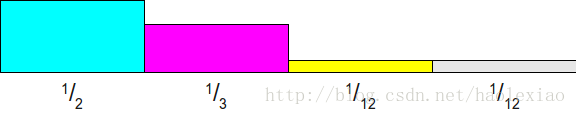

And then, we normalize all the probability by multiplying n for each item, where n is the number is the item. In this case, we would get an rectangle whose area is n:

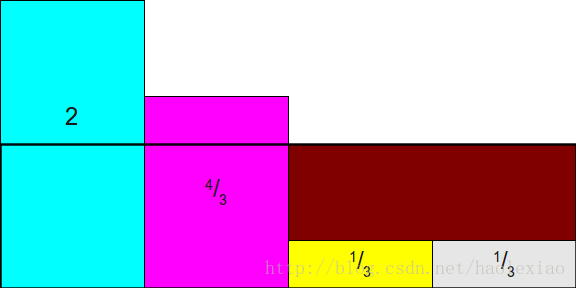

Finally, since some of the probability is not equal to 1, we should use the one larger than 1 to make the one smaller than 1 equal to 1. Remember, For each column, we **at most** put **two different** item in it:

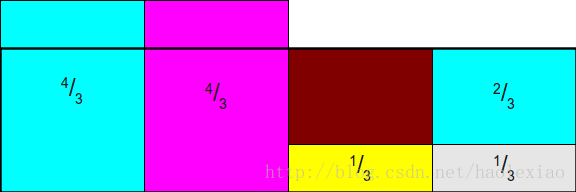

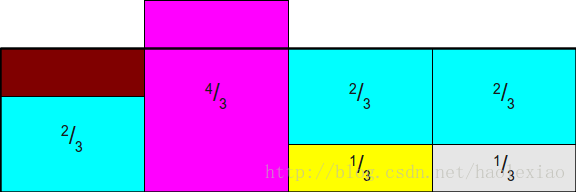

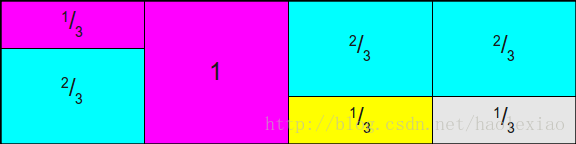

After constructing this alias table, we could use **O(1)** to sample edges and nodes. Each time we want to sample a item, we only need to roll dice two times. First, we select a column and then we select a item from this column(there would be at most two items in one column)

However, if we want to constrct this talbe, we should use **$O(n^2)$**, where n is the number of different items. To speed up, we could use **two queue**. One stores the ones whose probability is smaller than 1 and the other stores the ones whose probability is bigger than 1. Each time, we get a item from each of the two queues. We use the one from the bigger queue to make the smaller one to 1. After that, if the original bigger one is smaller than 1, we put it in to smaller queue. Otherwise, we put it into bigger queue. By performing this, we only need **O(n)** to construct alias table.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from sklearn.cluster import KMeans
import networkx as nx

In [ ]:
maxnode = 100
eachedge = maxnode // 50
dataset = {}

for i in range(maxnode):
  n1 = i
  count = 0
  while(count < eachedge):
    n2 = random.randint(0, maxnode - 1)
    w = random.randint(1, 100)
    dataset[(n1, n2)] = w
    count += 1


nodes = defaultdict(int)
nodeprobs = defaultdict(int)
edges = defaultdict(int)
edgeprobs = defaultdict(int)
weightsum = 0
nodeprobsum = 0
power = 0.75

for key in dataset:
  n1, n2 = key[0], key[1]
  w = dataset[key]
  nodes[int(n1)] += int(w)
  nodes[int(n2)] += 0
  nodeprobs[int(n1)] += int(w)
  nodeprobs[int(n2)] += 0
  edges[(int(n1), int(n2))] = int(w)
  edgeprobs[(int(n1), int(n2))] = int(w)
  weightsum += int(w)
  nodeprobsum += np.power(int(w), power)

for node in nodeprobs:
  nodeprobs[node] = np.power(nodeprobs[node], power) / nodeprobsum

for edge in edgeprobs:
  edgeprobs[edge] /= weightsum

print("num of nodes: {0}".format(len(nodes)))
print("num of edges: {0}".format(len(edges)))

num of nodes: 100
num of edges: 198


In [ ]:
class alias():
  def __init__(self, probs):
    self.n = len(probs)
    self.scaledprobs = {}
    self.table = {}
    self.aliastable = {}
    self.small = []
    self.big = []
    self.keys = list(probs.keys())

    for item in probs:
      prob = probs[item]
      self.scaledprobs[item] = prob * self.n
      if self.scaledprobs[item] > 1:
        self.big.append(item)
      elif self.scaledprobs[item] < 1:
        self.small.append(item)
      else:
        self.table[item] = 1
    
    while self.small and self.big:
      smallitem = self.small.pop()
      bigitem = self.big.pop()
      newprob = self.scaledprobs[bigitem] - (1 - self.scaledprobs[smallitem])
      self.table[smallitem] = self.scaledprobs[smallitem]
      self.aliastable[smallitem] = bigitem
      self.scaledprobs[bigitem] = newprob
      if self.scaledprobs[bigitem] > 1:
        self.big.append(bigitem)
      elif self.scaledprobs[bigitem] < 1:
        self.small.append(bigitem)
      else:
        self.table[bigitem] = 1
    
    while self.small:
      smallitem = self.small.pop()
      self.table[smallitem] = 1
    
    while self.big:
      bigitem = self.big.pop()
      self.table[bigitem] = 1

  def sampling_one(self):
    sample = random.choice(self.keys)
    if self.table[sample] >= random.uniform(0, 1):
      return sample
    else:
      return self.aliastable[sample]
  
  def sampling_n(self, n):
    samples = []
    for i in range(n):
      samples.append(self.sampling_one())
    return samples

In [ ]:
edgealias = alias(edgeprobs)
nodealias = alias(nodeprobs)

To sample negative edges, we should first sample negative nodes. And for each source node of the positive edge, we randomly select a node from negative node set. And then we check whether it's in the edge set of the graph. If yes, we abandon this one and continue select another one. If not, we add this edge as a negative edge.

In [ ]:
def sampling_negedge(edgealias, nodealias, batchsz):
  trainset = []
  edgesamples = edgealias.sampling_n(batchsz)
  nodesamples = nodealias.sampling_n(batchsz)
  for edge in edgesamples:
    n1 = edge[0]
    n2 = edge[1]
    trainset.append([n1, n2, 1])
    count = 0
    while(count < batchsz):
      n3 = random.choice(nodesamples)
      if (n1, n3) not in edges:
        trainset.append([n1, n3, -1])
        break
      count += 1
  return trainset

def one_hot(node):
  vec = [0] * len(nodes)
  vec[node] = 1
  return vec

def tensor_trainset(trainset):
  vi = []
  vj = []
  labels = []
  for item in trainset:
    vi.append(one_hot(item[0]))
    vj.append(one_hot(item[1]))
    labels.append(item[2])
  return torch.Tensor(vi), torch.Tensor(vj), torch.tensor(labels)

In [ ]:
lr = 0.01
batchsz = 64
batchnum = len(edges) // 64
epochs = 500
featuresz = 64
order = 1

In [ ]:
class LINE(nn.Module):
  def __init__(self, nodenum, featuresz, order=1):
    super(LINE, self).__init__()
    self.node_embeddings = nn.Linear(nodenum, featuresz, bias=False)
    self.order = order
    self.sigmoid = nn.LogSigmoid()
    if order == 2:
      self.contextnode_embeddings = nn.Linear(nodenum, featuresz, bias=False)
      self.contextnode_embeddings.weight.data = self.contextnode_embeddings.weight.data.uniform_(
                -.5, .5) / featuresz
    self.node_embeddings.weight.data = self.node_embeddings.weight.data.uniform_(
            -.5, .5) / featuresz
  def forward(self, vi, vj, labels):
    #viembeddings = torch.mul(vi, self.node_embeddings)
    viembeddings = self.node_embeddings(vi)
    if self.order == 1:
      vjembeddings = self.node_embeddings(vj)
    #  vjembeddings = torch.mul(vj, self.node_embeddings)
    elif self.order == 2:
      vjembeddings = self.contextnode_embeddings(vj)
    #  vjembeddings = torch.mul(vj, self.contextnode_embeddings)
    inner_product = torch.sum(viembeddings * vjembeddings, 1)
    loss = -torch.sum(self.sigmoid(inner_product * labels))
    return loss

In [ ]:
line = LINE(len(nodes), featuresz, order)
optimier = optim.SGD(line.parameters(), lr=lr)

In [ ]:
def train():
  line.train()
  for epoch in range(epochs):
    avgloss = 0
    for batch in range(batchnum):
      trainset = sampling_negedge(edgealias, nodealias, batchsz)
      vi, vj, labels = tensor_trainset(trainset)
      line.zero_grad()
      loss = line(vi, vj, labels)
      loss.backward()
      optimier.step()
      avgloss += loss
    avgloss /= batchnum * batchsz
    print("epoch: {0}, loss: {1}".format(epoch, avgloss))

In [ ]:
train()

epoch: 0, loss: 1.3862996101379395
epoch: 1, loss: 1.3863115310668945
epoch: 2, loss: 1.3862749338150024
epoch: 3, loss: 1.3862558603286743
epoch: 4, loss: 1.386251449584961
epoch: 5, loss: 1.3862558603286743
epoch: 6, loss: 1.3862419128417969
epoch: 7, loss: 1.3862375020980835
epoch: 8, loss: 1.3862262964248657
epoch: 9, loss: 1.3862085342407227
epoch: 10, loss: 1.3862162828445435
epoch: 11, loss: 1.3861942291259766
epoch: 12, loss: 1.3861745595932007
epoch: 13, loss: 1.3861833810806274
epoch: 14, loss: 1.386168360710144
epoch: 15, loss: 1.3861886262893677
epoch: 16, loss: 1.386154055595398
epoch: 17, loss: 1.386117935180664
epoch: 18, loss: 1.3861351013183594
epoch: 19, loss: 1.3861345052719116
epoch: 20, loss: 1.3861074447631836
epoch: 21, loss: 1.3860903978347778
epoch: 22, loss: 1.3860893249511719
epoch: 23, loss: 1.3860670328140259
epoch: 24, loss: 1.3860715627670288
epoch: 25, loss: 1.3860074281692505
epoch: 26, loss: 1.3860501050949097
epoch: 27, loss: 1.3860092163085938
epoch:

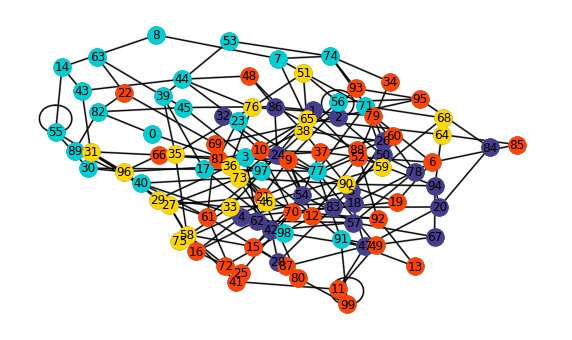

In [ ]:
embedding = line.node_embeddings.weight.T
num_coms = 4
clusters = KMeans(n_clusters=num_coms).fit_predict(embedding.detach().numpy())
communities = []
for i in range(num_coms):
  communities.append(set())
for i in range(len(clusters)):
  communities[clusters[i]].add(i)

G = nx.Graph()
for node in range(maxnode):
  G.add_node(node)

for item in edges:
  G.add_edge(item[0], item[1])

fig = plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, with_labels=True)
colors = ['#483D8B', '#00CED1', '#FF4500', '#FFD700']
for i in range(num_coms):
  nx.draw_networkx_nodes(G, pos, node_size=300, nodelist=list(communities[i]), node_color=colors[i])
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)
plt.axis("off")
plt.show()